In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split

import pytorch_lightning as pl
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks import EarlyStopping

import wandb
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler

import warnings
warnings.filterwarnings("ignore")

import pandas as pd
from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import NaNLabelEncoder, GroupNormalizer
from pytorch_forecasting.metrics import SMAPE, RMSE, QuantileLoss, PoissonLoss
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

AVAIL_GPUS = min(1, torch.cuda.device_count())
BATCH_SIZE = 128 if AVAIL_GPUS else 32

In [2]:
pl.seed_everything(125)

Global seed set to 125


125

In [3]:
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

## 1. Data Description

In [4]:
def gen_data(n, range_x=[-2, 2], scale_noise=0.2, sc=None):
    x = torch.linspace(range_x[0], range_x[1], n)
    y_true = x + torch.sin(x * 2 * torch.pi)
    y_noise = y_true + torch.randn((n,)) * scale_noise
    if sc is None:
        return x, y_noise, y_true
    else:
        y_true = sc.transform(y_true.reshape(-1, 1))
        y_noise = sc.transform(y_noise.reshape(-1, 1))
        y_true = torch.tensor(y_true, dtype=torch.float)
        y_noise = torch.tensor(y_noise, dtype=torch.float)
        return x, y_noise, y_true

arr_x, arr_y_noise, arr_y = gen_data(1500)

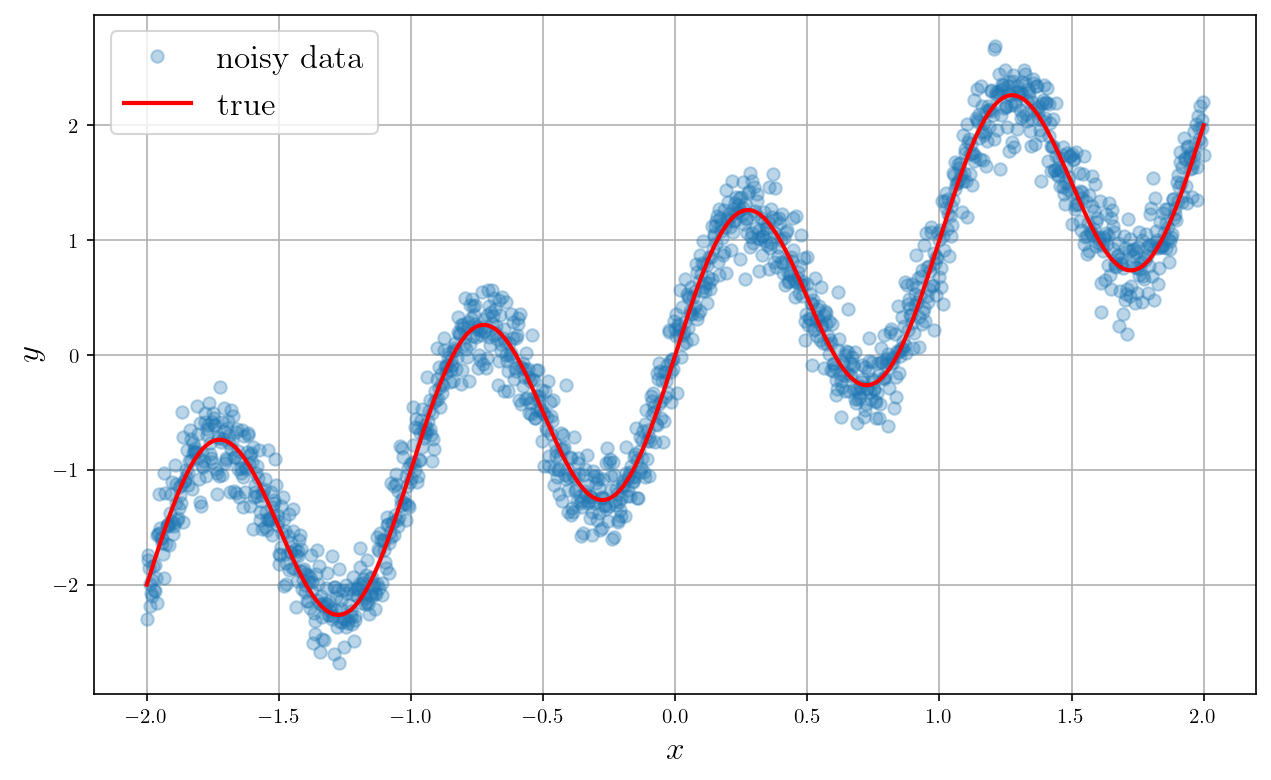

In [5]:
plt.figure(figsize=(10, 6), dpi=150)
plt.plot(arr_x, arr_y_noise, 'o', label='noisy data', alpha=0.3)
plt.plot(arr_x, arr_y, 'r-', linewidth=2,label='true')
plt.legend(fontsize=16)
plt.grid()
plt.xlabel(r"$x$", fontsize=16)
plt.ylabel(r"$y$", fontsize=16)
plt.show()

In [6]:
sc = MinMaxScaler()
sc.fit(arr_y.reshape(-1,1))
y_noise_norm = torch.tensor(sc.transform(arr_y_noise.reshape(-1,1)))
y_norm = torch.tensor(sc.transform(arr_y.reshape(-1,1)))
y_normalized = torch.column_stack([y_noise_norm, y_norm])

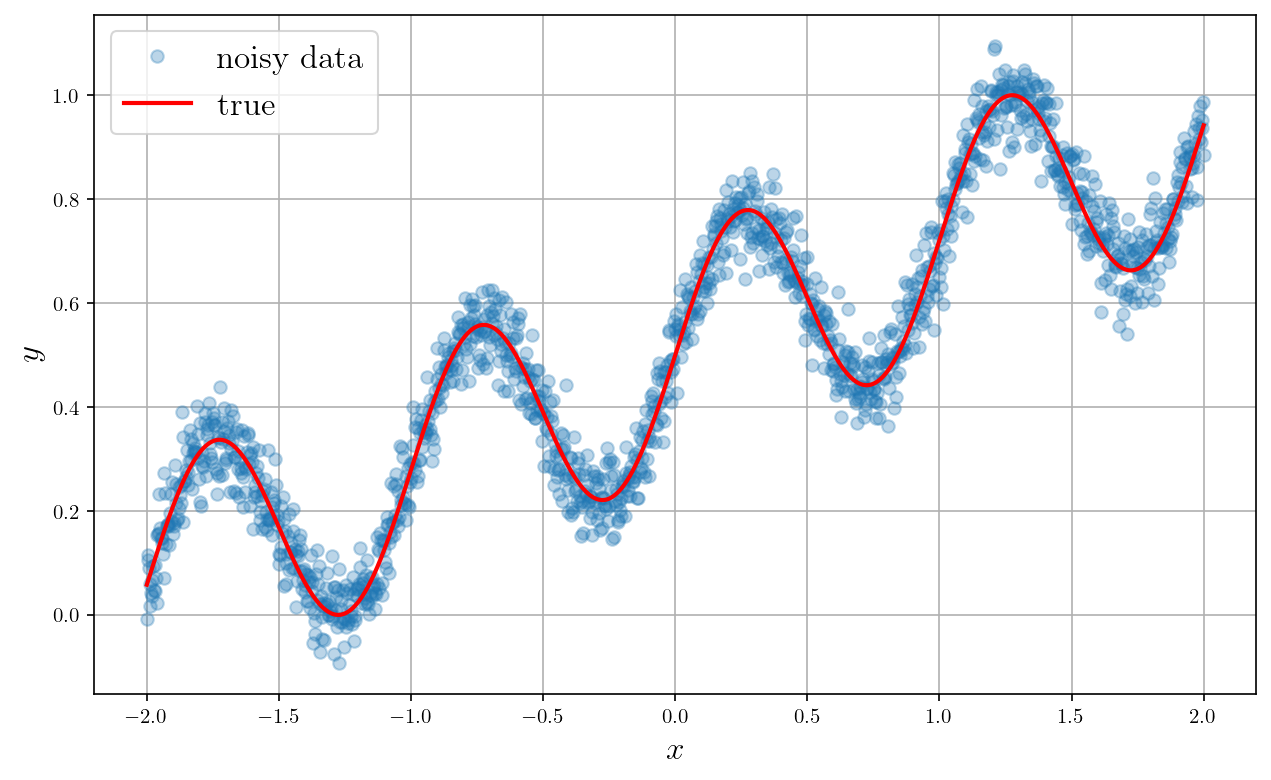

In [7]:
plt.figure(figsize=(10, 6), dpi=150)
plt.plot(arr_x, y_normalized[:,0], 'o', label='noisy data', alpha=0.3)
plt.plot(arr_x, y_normalized[:,1], 'r-', linewidth=2,label='true')
plt.legend(fontsize=16)
plt.grid()
plt.xlabel(r"$x$", fontsize=16)
plt.ylabel(r"$y$", fontsize=16)
plt.show()

## 2. Make Dataset

In [8]:
class NoisyData(Dataset):
    def __init__(self, x, y, y_true):
        self.x = x.reshape((-1,1))
        self.y = y.reshape((-1,1))
        self.y_true = y_true.reshape((-1,1))
        
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        return self.x[idx], self.y[idx], self.y_true[idx]

In [9]:
def gen_noisy_data(n, range_x=[-2,4], sc=None):
    return NoisyData(*gen_data(n, range_x=range_x, sc=sc))

## 3. MLP 1

### 3.1. Define Model

In [10]:
class NoisyNet(pl.LightningModule):
    def __init__(self, N=10000, hparams=None):
        super().__init__()
        
        self.N = N
        
        self.net = nn.Sequential(
            nn.Linear(1, 64),
            nn.ReLU(inplace=True),
            nn.Linear(64, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, 64),
            nn.ReLU(inplace=True),
            nn.Linear(64, 1)
        )
        
        self.learning_rate = hparams['learning_rate']
        self.batch_size = hparams['batch_size']
        self.epochs = hparams['epochs']
        
        self.save_hyperparameters(hparams)
    
    def forward(self, x):
        return self.net(x)
    
    def training_step(self, batch, batch_idx):
        X, y, _ = batch
        y_hat = self(X)
        
        loss = F.mse_loss(y, y_hat)
        
        self.log('train_loss', loss)
        
        return loss
    
    def validation_step(self, batch, batch_idx):
        X, y, _ = batch
        y_hat = self(X)
        
        loss = F.mse_loss(y, y_hat)
        
        self.log('val_loss', loss)
        
        return loss
    
    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=self.learning_rate)
        return optimizer
    
    def prepare_data(self):
        self.ds = NoisyData(*gen_data(self.N, range_x=[-2, 2], sc=sc))
        self.ds2 = NoisyData(*gen_data(self.N // 5, range_x=[-2, 2], sc=sc))
        
    def setup(self, stage=None):
        N_train = self.N // 10 * 7
        N_val = self.N - N_train
        if stage == "fit" or stage is None:
            self.ds_train, self.ds_val = random_split(self.ds, [N_train, N_val])
        if stage == "test" or stage is None:
            _, self.ds_test = random_split(self.ds2, [N_train, N_val])
            
    def train_dataloader(self):
        return DataLoader(self.ds_train, batch_size=self.batch_size)
    
    def val_dataloader(self):
        return DataLoader(self.ds_val, batch_size=self.batch_size)
    
    def test_dataloader(self):
        return DataLoader(self.ds_test, batch_size=self.batch_size)

In [11]:
# hparams = {
#     "learning_rate": 1e-3,
#     "batch_size": BATCH_SIZE,
#     "epochs": 10000
# }

# model = NoisyNet(
#     hparams=hparams
# )

# wandb_logger = WandbLogger(
#     project='MLP2Autoregressive'
# )

# trainer = Trainer(
#     logger=wandb_logger,
#     max_epochs=hparams['epochs'],
#     gpus=AVAIL_GPUS,
#     enable_progress_bar=False,
#     callbacks=[
#         EarlyStopping(monitor='val_loss', patience=50, mode='min')
#     ]
    
# )

### 3.2. Train

In [12]:
# trainer.fit(model)

In [13]:
# wandb.finish()

In [14]:
# best_path = trainer.checkpoint_callback.best_model_path
# print(best_path)
best_path = "/home/xteca/Documents/Project/Machine_Learning/MLTest/MLP2Autoregressive/2nakj4gy/checkpoints/epoch=103-step=5720.ckpt"
best_model = NoisyNet.load_from_checkpoint(best_path)
best_model.eval()

NoisyNet(
  (net): Sequential(
    (0): Linear(in_features=1, out_features=64, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=64, out_features=128, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=128, out_features=128, bias=True)
    (5): ReLU(inplace=True)
    (6): Linear(in_features=128, out_features=64, bias=True)
    (7): ReLU(inplace=True)
    (8): Linear(in_features=64, out_features=1, bias=True)
  )
)

### 3.3. Test

In [15]:
test_data = gen_noisy_data(1000, range_x=[-2,2], sc=sc)
x = test_data.x
y = test_data.y
y_true = test_data.y_true
y_hat = best_model(x).detach().cpu().numpy()

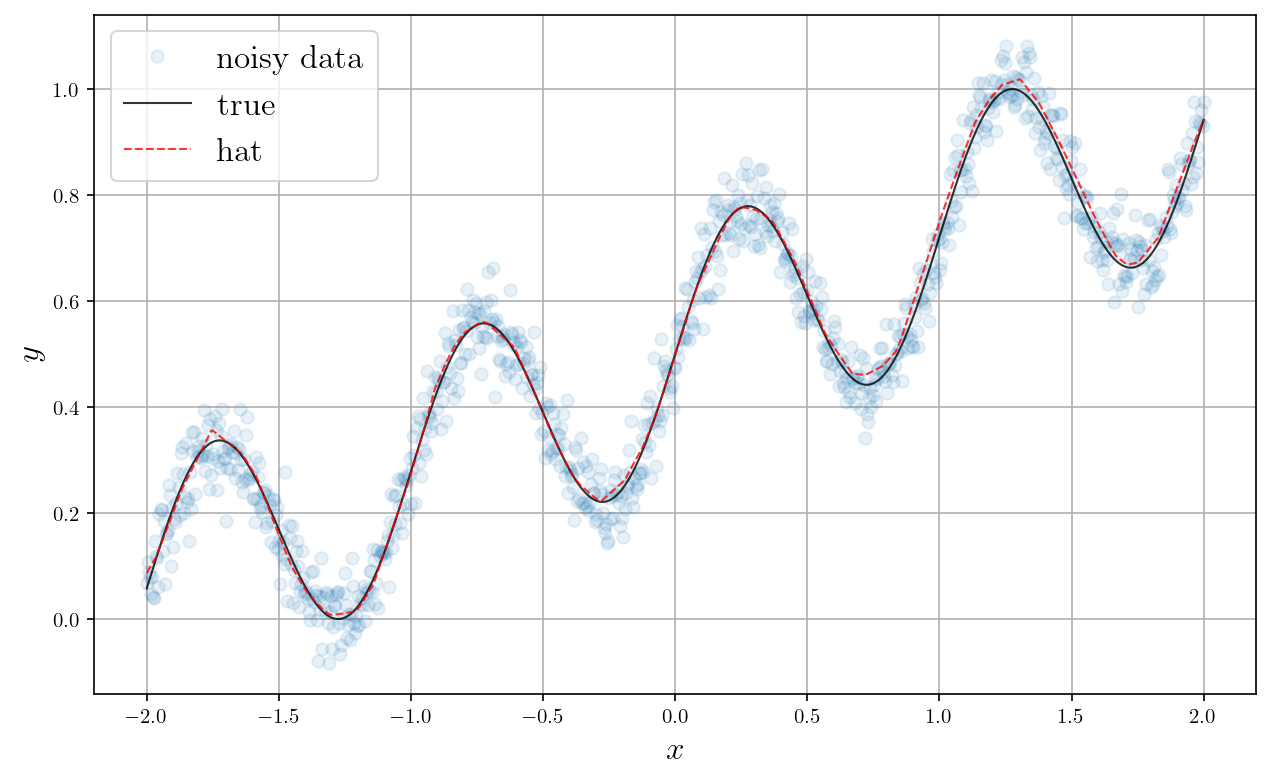

In [16]:
plt.figure(figsize=(10, 6), dpi=150)
plt.plot(x, y, 'o', label='noisy data', alpha=0.1)
plt.plot(x, y_true, 'k-', linewidth=1, label='true', alpha=0.8)
plt.plot(x, y_hat, 'r--', linewidth=1, label='hat', alpha=0.8)
plt.legend(fontsize=16)
plt.grid()
plt.xlabel(r"$x$", fontsize=16)
plt.ylabel(r"$y$", fontsize=16)
plt.show()

In [17]:
inv = sc.inverse_transform

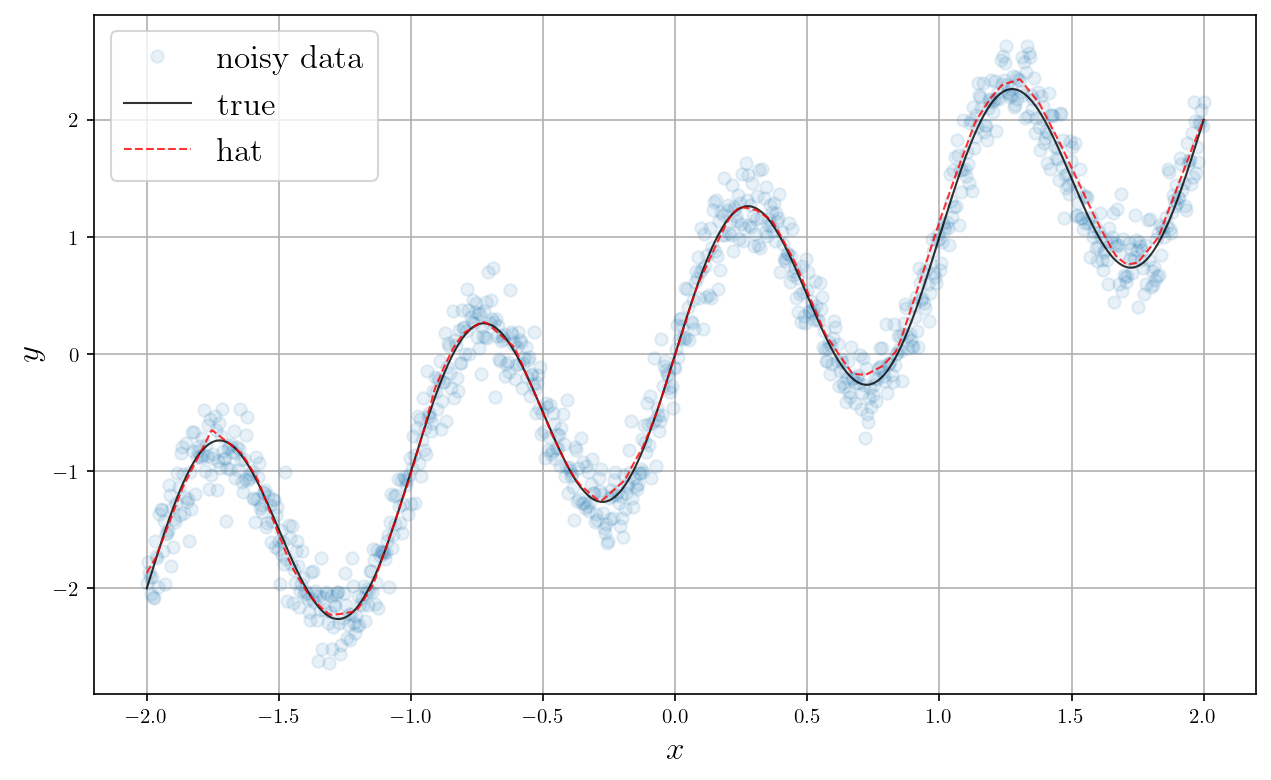

In [18]:
plt.figure(figsize=(10, 6), dpi=150)
plt.plot(x, inv(y), 'o', label='noisy data', alpha=0.1)
plt.plot(x, inv(y_true), 'k-', linewidth=1, label='true', alpha=0.8)
plt.plot(x, inv(y_hat), 'r--', linewidth=1, label='hat', alpha=0.8)
plt.legend(fontsize=16)
plt.grid()
plt.xlabel(r"$x$", fontsize=16)
plt.ylabel(r"$y$", fontsize=16)
plt.show()

## 4. TimeSeries Data

In [19]:
ts_data = pd.DataFrame(
    dict(
        y=y_hat.flatten(),
        group=np.repeat(0, len(y)),
        time_idx=np.arange(len(y_hat))
    )
)
ts_data

,y,group,time_idx
0,0.087055,0,0
1,0.090470,0,1
2,0.093888,0,2
3,0.097306,0,3
4,0.100724,0,4
...,...,...,...
995,0.923153,0,995
996,0.928190,0,996
997,0.933196,0,997
998,0.938066,0,998


In [20]:
ts_data = ts_data.astype(dict(group=str))

In [21]:
max_encoder_length = 100
max_prediction_length = 20

cutoff = ts_data["time_idx"].max() - max_prediction_length

ds_train = TimeSeriesDataSet(
    ts_data[lambda x: x.time_idx <= cutoff],
    target="y",
    time_idx="time_idx",
#     categorical_encoders={"group": NaNLabelEncoder().fit(ts_data.group)},
    group_ids=["group"],
    time_varying_known_reals=["time_idx"],
    time_varying_unknown_reals=["y"],
    max_encoder_length=max_encoder_length,
    max_prediction_length=max_prediction_length
)

ds_val = TimeSeriesDataSet.from_dataset(ds_train, ts_data, min_prediction_idx=cutoff + 1)

In [22]:
ds_val.get_parameters()

{'time_idx': 'time_idx',
 'target': 'y',
 'group_ids': ['group'],
 'weight': None,
 'max_encoder_length': 100,
 'min_encoder_length': 100,
 'min_prediction_idx': 980,
 'min_prediction_length': 20,
 'max_prediction_length': 20,
 'static_categoricals': [],
 'static_reals': [],
 'time_varying_known_categoricals': [],
 'time_varying_known_reals': ['time_idx'],
 'time_varying_unknown_categoricals': [],
 'time_varying_unknown_reals': ['y'],
 'variable_groups': {},
 'constant_fill_strategy': {},
 'allow_missing_timesteps': False,
 'lags': {},
 'add_relative_time_idx': False,
 'add_target_scales': False,
 'add_encoder_length': False,
 'target_normalizer': EncoderNormalizer(method='standard', center=True, max_length=None, transformation='relu'),
 'categorical_encoders': {'__group_id__group': NaNLabelEncoder(add_nan=False, warn=True)},
 'scalers': {'time_idx': StandardScaler()},
 'randomize_length': None,
 'predict_mode': False}

In [23]:
ts_dl = ds_val.to_dataloader(batch_size=2)

x, y = next(iter(ts_dl))

In [24]:
x

{'encoder_cat': tensor([], size=(1, 100, 0), dtype=torch.int64),
 'encoder_cont': tensor([[[ 1.3803,  1.8083],
          [ 1.3839,  1.7260],
          [ 1.3874,  1.6437],
          [ 1.3909,  1.5614],
          [ 1.3945,  1.4791],
          [ 1.3980,  1.3968],
          [ 1.4015,  1.3145],
          [ 1.4051,  1.2324],
          [ 1.4086,  1.1509],
          [ 1.4122,  1.0695],
          [ 1.4157,  0.9884],
          [ 1.4192,  0.9076],
          [ 1.4228,  0.8269],
          [ 1.4263,  0.7462],
          [ 1.4298,  0.6659],
          [ 1.4334,  0.5879],
          [ 1.4369,  0.5099],
          [ 1.4404,  0.4338],
          [ 1.4440,  0.3583],
          [ 1.4475,  0.2827],
          [ 1.4510,  0.2072],
          [ 1.4546,  0.1317],
          [ 1.4581,  0.0583],
          [ 1.4616, -0.0123],
          [ 1.4652, -0.0829],
          [ 1.4687, -0.1534],
          [ 1.4722, -0.2240],
          [ 1.4758, -0.2946],
          [ 1.4793, -0.3651],
          [ 1.4828, -0.4357],
          [ 1.4864,

In [25]:
y

(tensor([[0.8461, 0.8513, 0.8565, 0.8617, 0.8669, 0.8721, 0.8774, 0.8826, 0.8879,
          0.8929, 0.8980, 0.9030, 0.9080, 0.9131, 0.9181, 0.9232, 0.9282, 0.9332,
          0.9381, 0.9429]]),
 None)

In [26]:
dl_train = ds_train.to_dataloader(
    train=True, batch_size=100, num_workers=0, batch_sampler="synchronized"
)

dl_val = ds_val.to_dataloader(
    train=False, batch_size=100, num_workers=0, batch_sampler="synchronized"
)

In [27]:
# calc basline abs error
actuals = torch.cat([y[0] for x, y in iter(dl_val)])
baseline_pred = Baseline().predict(dl_val)
SMAPE()(baseline_pred, actuals)

tensor(0.0619)

## 5. Temporal Fusion Transformer

In [28]:
pl.seed_everything(125)

model2 = TemporalFusionTransformer.from_dataset(
    ds_train,
    learning_rate=0.0016980954145099992,
    hidden_size=20,
    attention_head_size=4,
    dropout=0.1,
    hidden_continuous_size=10,
    output_size=7, # 7-quantiles
    loss=QuantileLoss(),
    reduce_on_plateau_patience=4,
)

print(f"Number of parameters in network: {model2.size()/1e3:.1f}k")

Global seed set to 125


Number of parameters in network: 23.7k


In [29]:
wandb_logger = WandbLogger(
    project='MLP2Autoregressive'
)

trainer = Trainer(
    logger=wandb_logger,
    gpus=AVAIL_GPUS,
    gradient_clip_val=1e-1,
    enable_progress_bar=False,
)

wandb: Currently logged in as: axect (use `wandb login --relogin` to force relogin)


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [30]:
model2.predict(ds_val)

tensor([[0.7326, 0.7314, 0.7308, 0.7306, 0.7305, 0.7305, 0.7305, 0.7305, 0.7306,
         0.7307, 0.7307, 0.7308, 0.7309, 0.7309, 0.7310, 0.7311, 0.7311, 0.7312,
         0.7313, 0.7313]])

In [31]:
# # find optimal learning rate
# res = trainer.tuner.lr_find(
#     model2,
#     train_dataloaders=dl_train,
#     val_dataloaders=dl_val,
#     max_lr=10.0,
#     min_lr=1e-6,
# )

# print(f"suggested learning rate: {res.suggestion()}")
# fig = res.plot(show=True, suggest=True)
# fig.show()

In [32]:
# model2 = TemporalFusionTransformer.from_dataset(
#     ds_train,
#     learning_rate=res.suggestion(),
#     hidden_size=20,
#     attention_head_size=1,
#     dropout=0.1,
#     hidden_continuous_size=10,
#     output_size=7, # 7-quantiles
#     loss=QuantileLoss(),
# #     reduce_on_plateau_patience=4,
# )

In [33]:
early_stop_callback = EarlyStopping(
    monitor="val_loss",
    min_delta=1e-4,
    patience=10,
    verbose=False,
    mode="min"
)

trainer = Trainer(
    logger=wandb_logger,
    max_epochs=30,
    gpus=AVAIL_GPUS,
    weights_summary="top",
    gradient_clip_val=0.1,
    callbacks=[early_stop_callback],
    enable_progress_bar=False,
)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [34]:
trainer.fit(model2, train_dataloaders=dl_train, val_dataloaders=dl_val)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 0     
3  | prescalers                         | ModuleDict                      | 40    
4  | static_variable_selection          | VariableSelectionNetwork        | 0     
5  | encoder_variable_selection         | VariableSelectionNetwork        | 1.7 K 
6  | decoder_variable_selection         | VariableSelectionNetwork        | 780   
7  | static_context_variable_selection  | GatedResidualNetwork            | 1.7 K 
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 1.7 K 
9  | static_context_initial_cell_lstm 

In [35]:
wandb.finish()

epoch,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇████
train_loss_epoch,█▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss_step,▅▃█▄▃▅▃▂▄▁▂▁▂▂▂▂▁▃▂▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁
trainer/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
val_MAE,█▆▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁
val_MAPE,█▆▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁
val_RMSE,█▆▂▃▂▂▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁
val_SMAPE,█▅▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,24
train_loss_epoch,0.00443


In [36]:
best_path2 = trainer.checkpoint_callback.best_model_path
print(best_path2)
best_model2 = TemporalFusionTransformer.load_from_checkpoint(best_path2)
best_model2.eval()

/home/xteca/Documents/Project/Machine_Learning/MLTest/MLP2Autoregressive/enhfrtec/checkpoints/epoch=23-step=20664.ckpt


TemporalFusionTransformer(
  	"attention_head_size":               4
  	"categorical_groups":                {}
  	"causal_attention":                  True
  	"dropout":                           0.1
  	"embedding_labels":                  {}
  	"embedding_paddings":                []
  	"embedding_sizes":                   {}
  	"hidden_continuous_size":            10
  	"hidden_continuous_sizes":           {}
  	"hidden_size":                       20
  	"learning_rate":                     0.0016980954145099992
  	"log_gradient_flow":                 False
  	"log_interval":                      -1
  	"log_val_interval":                  -1
  	"logging_metrics":                   ModuleList(
  	  (0): SMAPE()
  	  (1): MAE()
  	  (2): RMSE()
  	  (3): MAPE()
  	)
  	"loss":                              QuantileLoss(quantiles=[0.02, 0.1, 0.25, 0.5, 0.75, 0.9, 0.98])
  	"lstm_layers":                       1
  	"max_encoder_length":                100
  	"monotone_constaints":       

In [37]:
# calc baseline abs error
actuals = torch.cat([y[0] for x, y in iter(dl_val)])
predictions = best_model2.predict(dl_val)
(actuals - predictions).abs().mean()

tensor(0.0058)

In [38]:
raw_preds, x = best_model2.predict(dl_val, mode="raw", return_x=True)

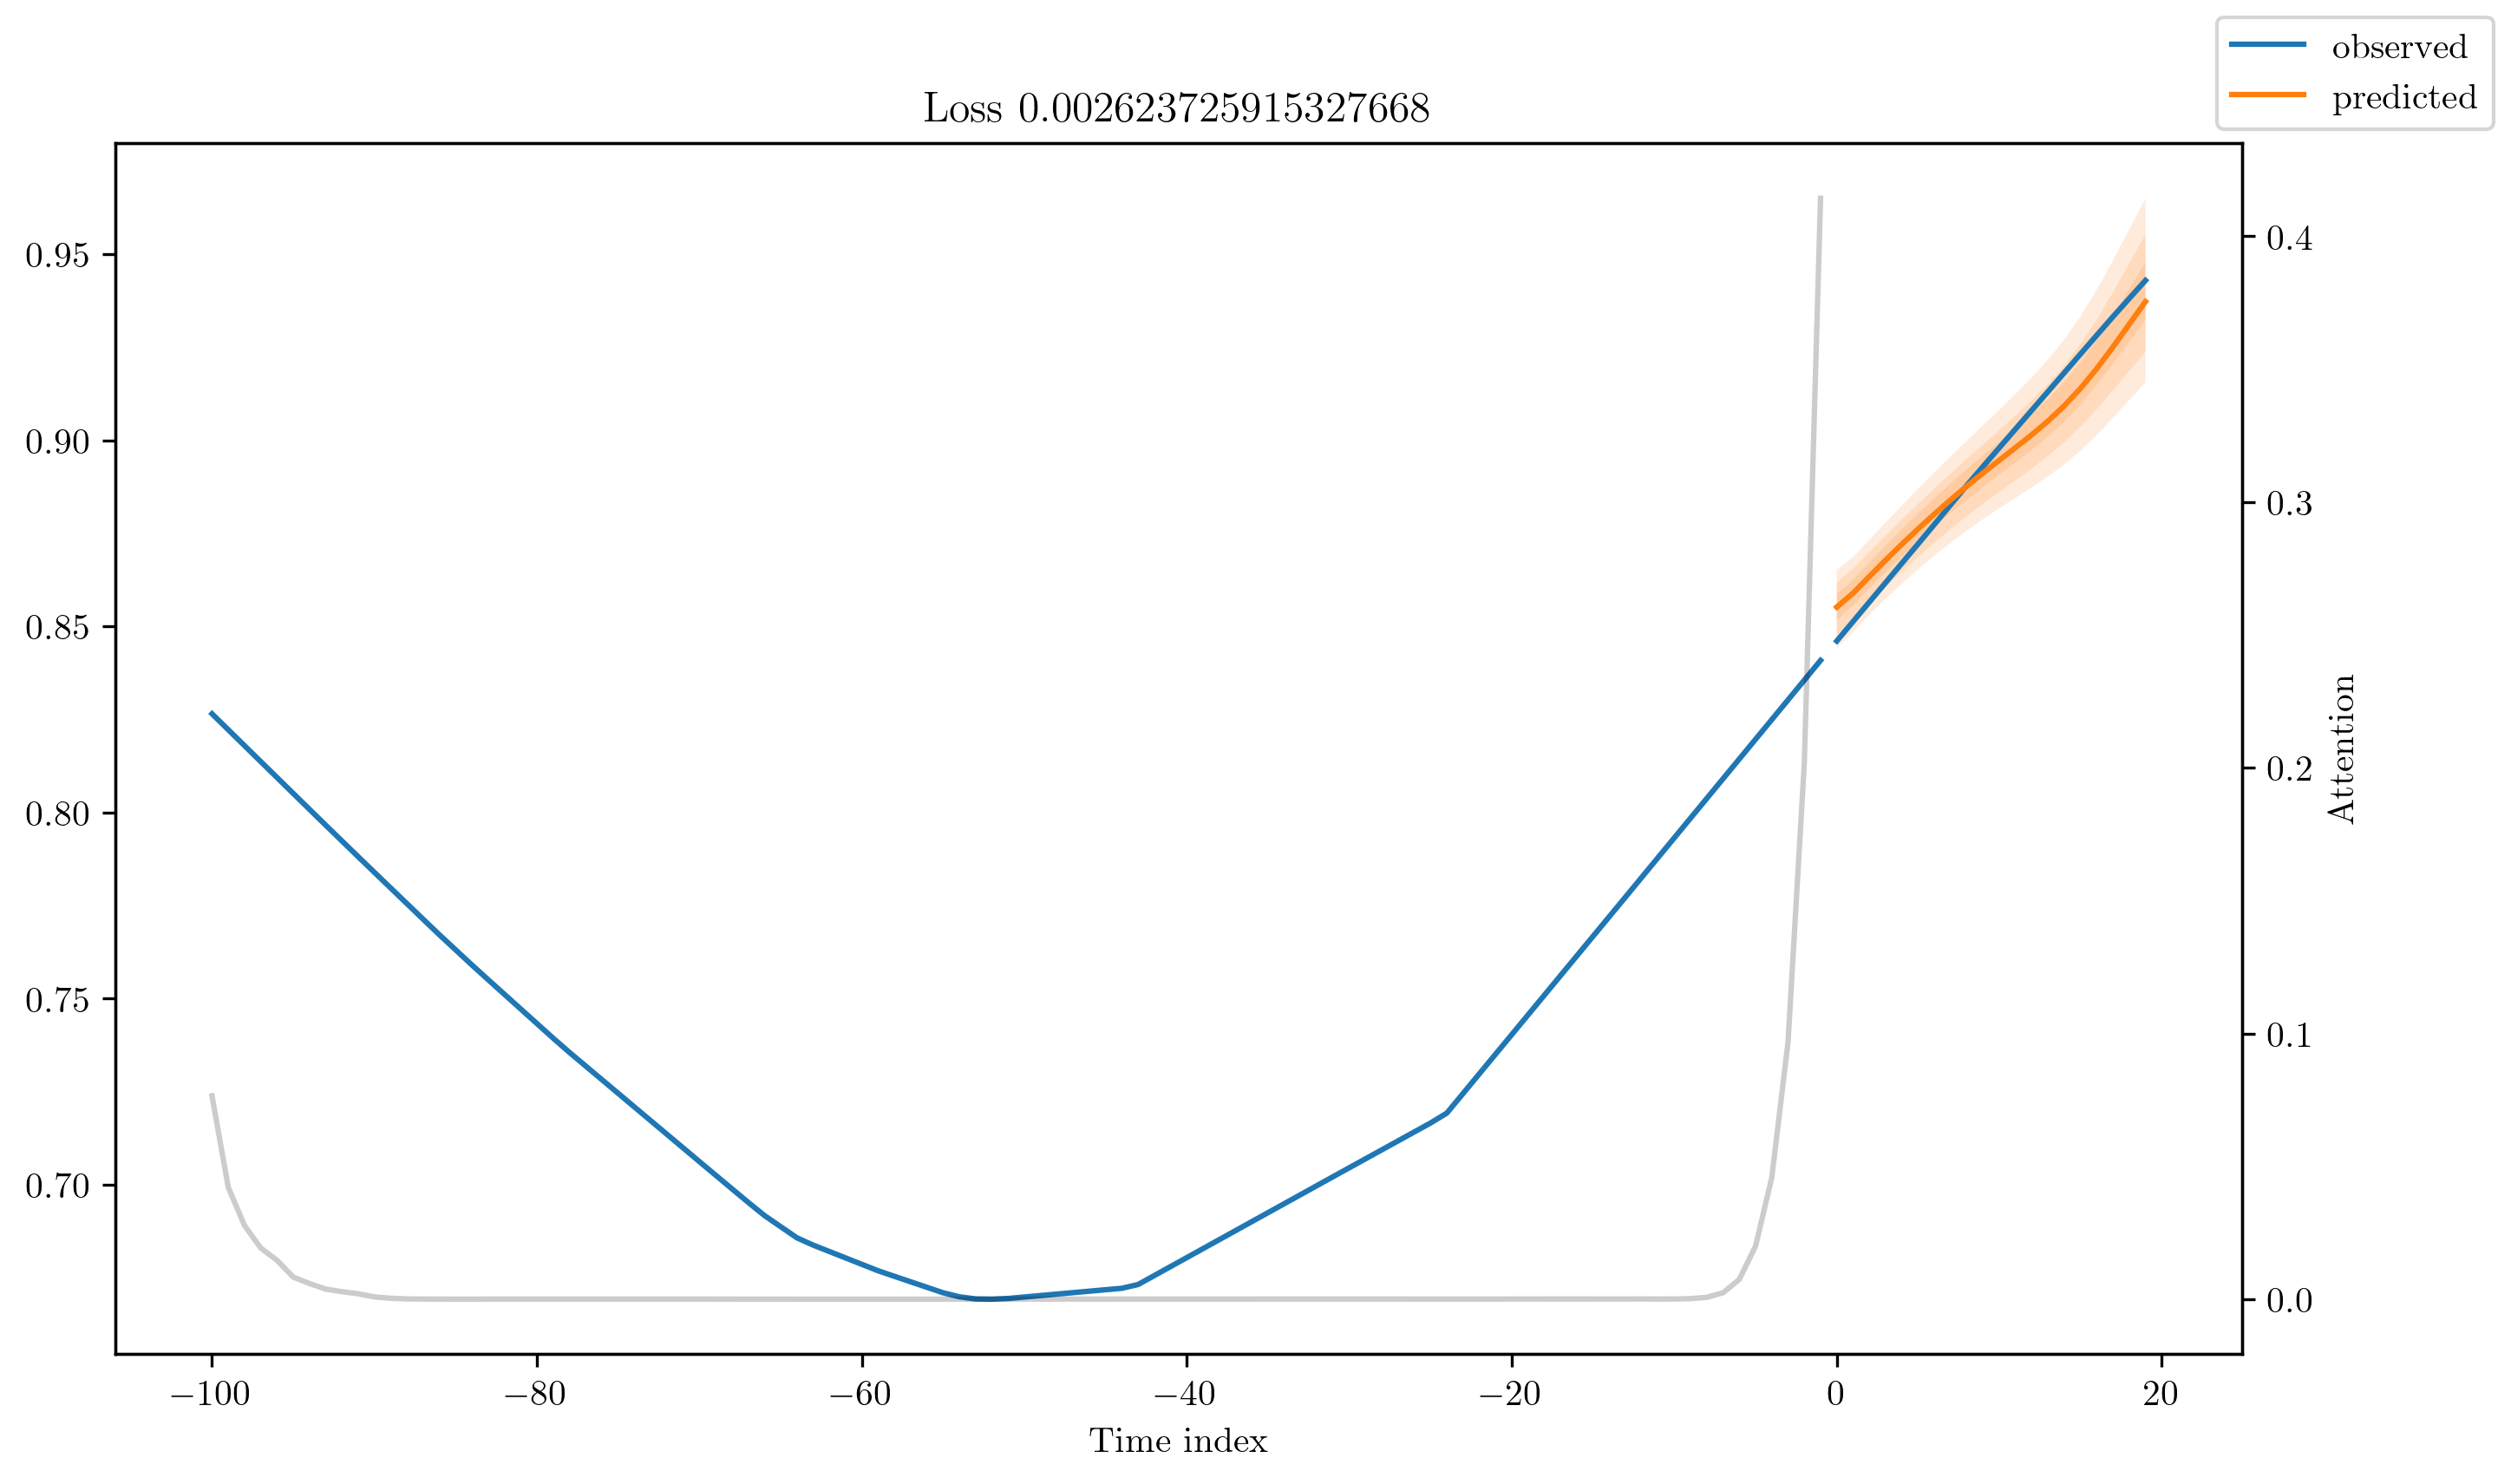

In [39]:
fig = best_model2.plot_prediction(x, raw_preds, idx=0, add_loss_to_title=True)
fig.set_dpi(300)
fig.set_figwidth(10)
fig.set_figheight(6)
fig.savefig("tft_loss.png")
fig.show()

The grey lines denote the amount of attention the model pays to different points in time when making the prediction

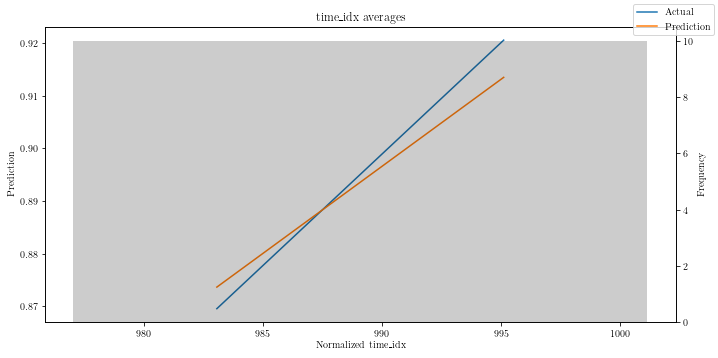

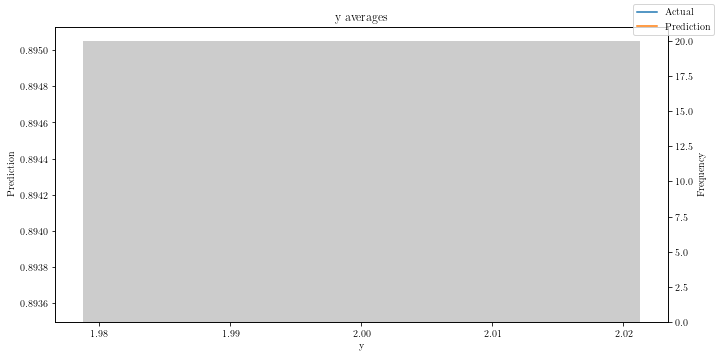

In [40]:
predictions, x_p = best_model2.predict(dl_val, return_x=True)
predictions_vs_actuals = best_model2.calculate_prediction_actual_by_variable(x_p, predictions)
best_model2.plot_prediction_actual_by_variable(predictions_vs_actuals);

In [41]:
x_val, y_val = ds_val[0]

In [42]:
x_val['encoder_target']

tensor([0.8265, 0.8222, 0.8180, 0.8137, 0.8094, 0.8051, 0.8009, 0.7966, 0.7924,
        0.7881, 0.7839, 0.7797, 0.7755, 0.7713, 0.7672, 0.7631, 0.7590, 0.7551,
        0.7512, 0.7472, 0.7433, 0.7394, 0.7356, 0.7319, 0.7282, 0.7246, 0.7209,
        0.7172, 0.7136, 0.7099, 0.7062, 0.7026, 0.6989, 0.6953, 0.6918, 0.6888,
        0.6858, 0.6838, 0.6821, 0.6804, 0.6786, 0.6769, 0.6754, 0.6740, 0.6725,
        0.6710, 0.6699, 0.6694, 0.6693, 0.6695, 0.6699, 0.6703, 0.6707, 0.6711,
        0.6714, 0.6718, 0.6722, 0.6732, 0.6756, 0.6781, 0.6805, 0.6829, 0.6853,
        0.6877, 0.6901, 0.6925, 0.6950, 0.6974, 0.6998, 0.7022, 0.7046, 0.7070,
        0.7094, 0.7118, 0.7142, 0.7166, 0.7193, 0.7246, 0.7298, 0.7351, 0.7404,
        0.7457, 0.7509, 0.7562, 0.7615, 0.7668, 0.7721, 0.7773, 0.7826, 0.7879,
        0.7932, 0.7985, 0.8038, 0.8091, 0.8144, 0.8197, 0.8250, 0.8303, 0.8356,
        0.8409])

In [43]:
y_val[0]

tensor([0.8461, 0.8513, 0.8565, 0.8617, 0.8669, 0.8721, 0.8774, 0.8826, 0.8879,
        0.8929, 0.8980, 0.9030, 0.9080, 0.9131, 0.9181, 0.9232, 0.9282, 0.9332,
        0.9381, 0.9429])

In [44]:
new_x_val = torch.concat([x_val['encoder_target'][20:], y_val[0]])

In [45]:
new_x_val.shape

torch.Size([100])

In [46]:
ds_val

TimeSeriesDataSet[length=1](
	time_idx='time_idx',
	target='y',
	group_ids=['group'],
	weight=None,
	max_encoder_length=100,
	min_encoder_length=100,
	min_prediction_idx=980,
	min_prediction_length=20,
	max_prediction_length=20,
	static_categoricals=[],
	static_reals=[],
	time_varying_known_categoricals=[],
	time_varying_known_reals=['time_idx'],
	time_varying_unknown_categoricals=[],
	time_varying_unknown_reals=['y'],
	variable_groups={},
	constant_fill_strategy={},
	allow_missing_timesteps=False,
	lags={},
	add_relative_time_idx=False,
	add_target_scales=False,
	add_encoder_length=False,
	target_normalizer=EncoderNormalizer(method='standard', center=True, max_length=None, transformation='relu'),
	categorical_encoders={'__group_id__group': NaNLabelEncoder(add_nan=False, warn=True)},
	scalers={'time_idx': StandardScaler()},
	randomize_length=None,
	predict_mode=False
)

In [47]:
x_val, y_val = ds_val[0]

In [48]:
ts_test = pd.DataFrame(
    dict(
        y=torch.concat([x_val['encoder_target'][20:], y_val[0], torch.repeat_interleave(torch.tensor(0), 20)]),
        group=np.repeat(0, 120),
        time_idx=np.arange(900,1020)
    )
)
ts_test = ts_test.astype(dict(group=str))
ts_test

,y,group,time_idx
0,0.743314,0,900
1,0.739389,0,901
2,0.735575,0,902
3,0.731908,0,903
4,0.728241,0,904
...,...,...,...
115,0.000000,0,1015
116,0.000000,0,1016
117,0.000000,0,1017
118,0.000000,0,1018


In [49]:
max_encoder_length = 100
max_prediction_length = 20

ds_test = TimeSeriesDataSet(
    ts_test,
    target="y",
    time_idx="time_idx",
    group_ids=["group"],
    time_varying_known_reals=["time_idx"],
    time_varying_unknown_reals=["y"],
    max_encoder_length=max_encoder_length,
    max_prediction_length=max_prediction_length
)

In [50]:
ds_test

TimeSeriesDataSet[length=1](
	time_idx='time_idx',
	target='y',
	group_ids=['group'],
	weight=None,
	max_encoder_length=100,
	min_encoder_length=100,
	min_prediction_idx=900,
	min_prediction_length=20,
	max_prediction_length=20,
	static_categoricals=[],
	static_reals=[],
	time_varying_known_categoricals=[],
	time_varying_known_reals=['time_idx'],
	time_varying_unknown_categoricals=[],
	time_varying_unknown_reals=['y'],
	variable_groups={},
	constant_fill_strategy={},
	allow_missing_timesteps=False,
	lags={},
	add_relative_time_idx=False,
	add_target_scales=False,
	add_encoder_length=False,
	target_normalizer=EncoderNormalizer(method='standard', center=True, max_length=None, transformation=None),
	categorical_encoders={'__group_id__group': NaNLabelEncoder(add_nan=False, warn=True)},
	scalers={'time_idx': StandardScaler()},
	randomize_length=None,
	predict_mode=False
)

In [51]:
best_model2.predict(ds_test)

tensor([[0.9561, 0.9590, 0.9646, 0.9705, 0.9764, 0.9824, 0.9884, 0.9943, 1.0001,
         1.0057, 1.0113, 1.0168, 1.0222, 1.0275, 1.0326, 1.0375, 1.0423, 1.0471,
         1.0520, 1.0568]])

In [52]:
raw_tests, x_new = best_model2.predict(ds_test, mode="raw", return_x=True)

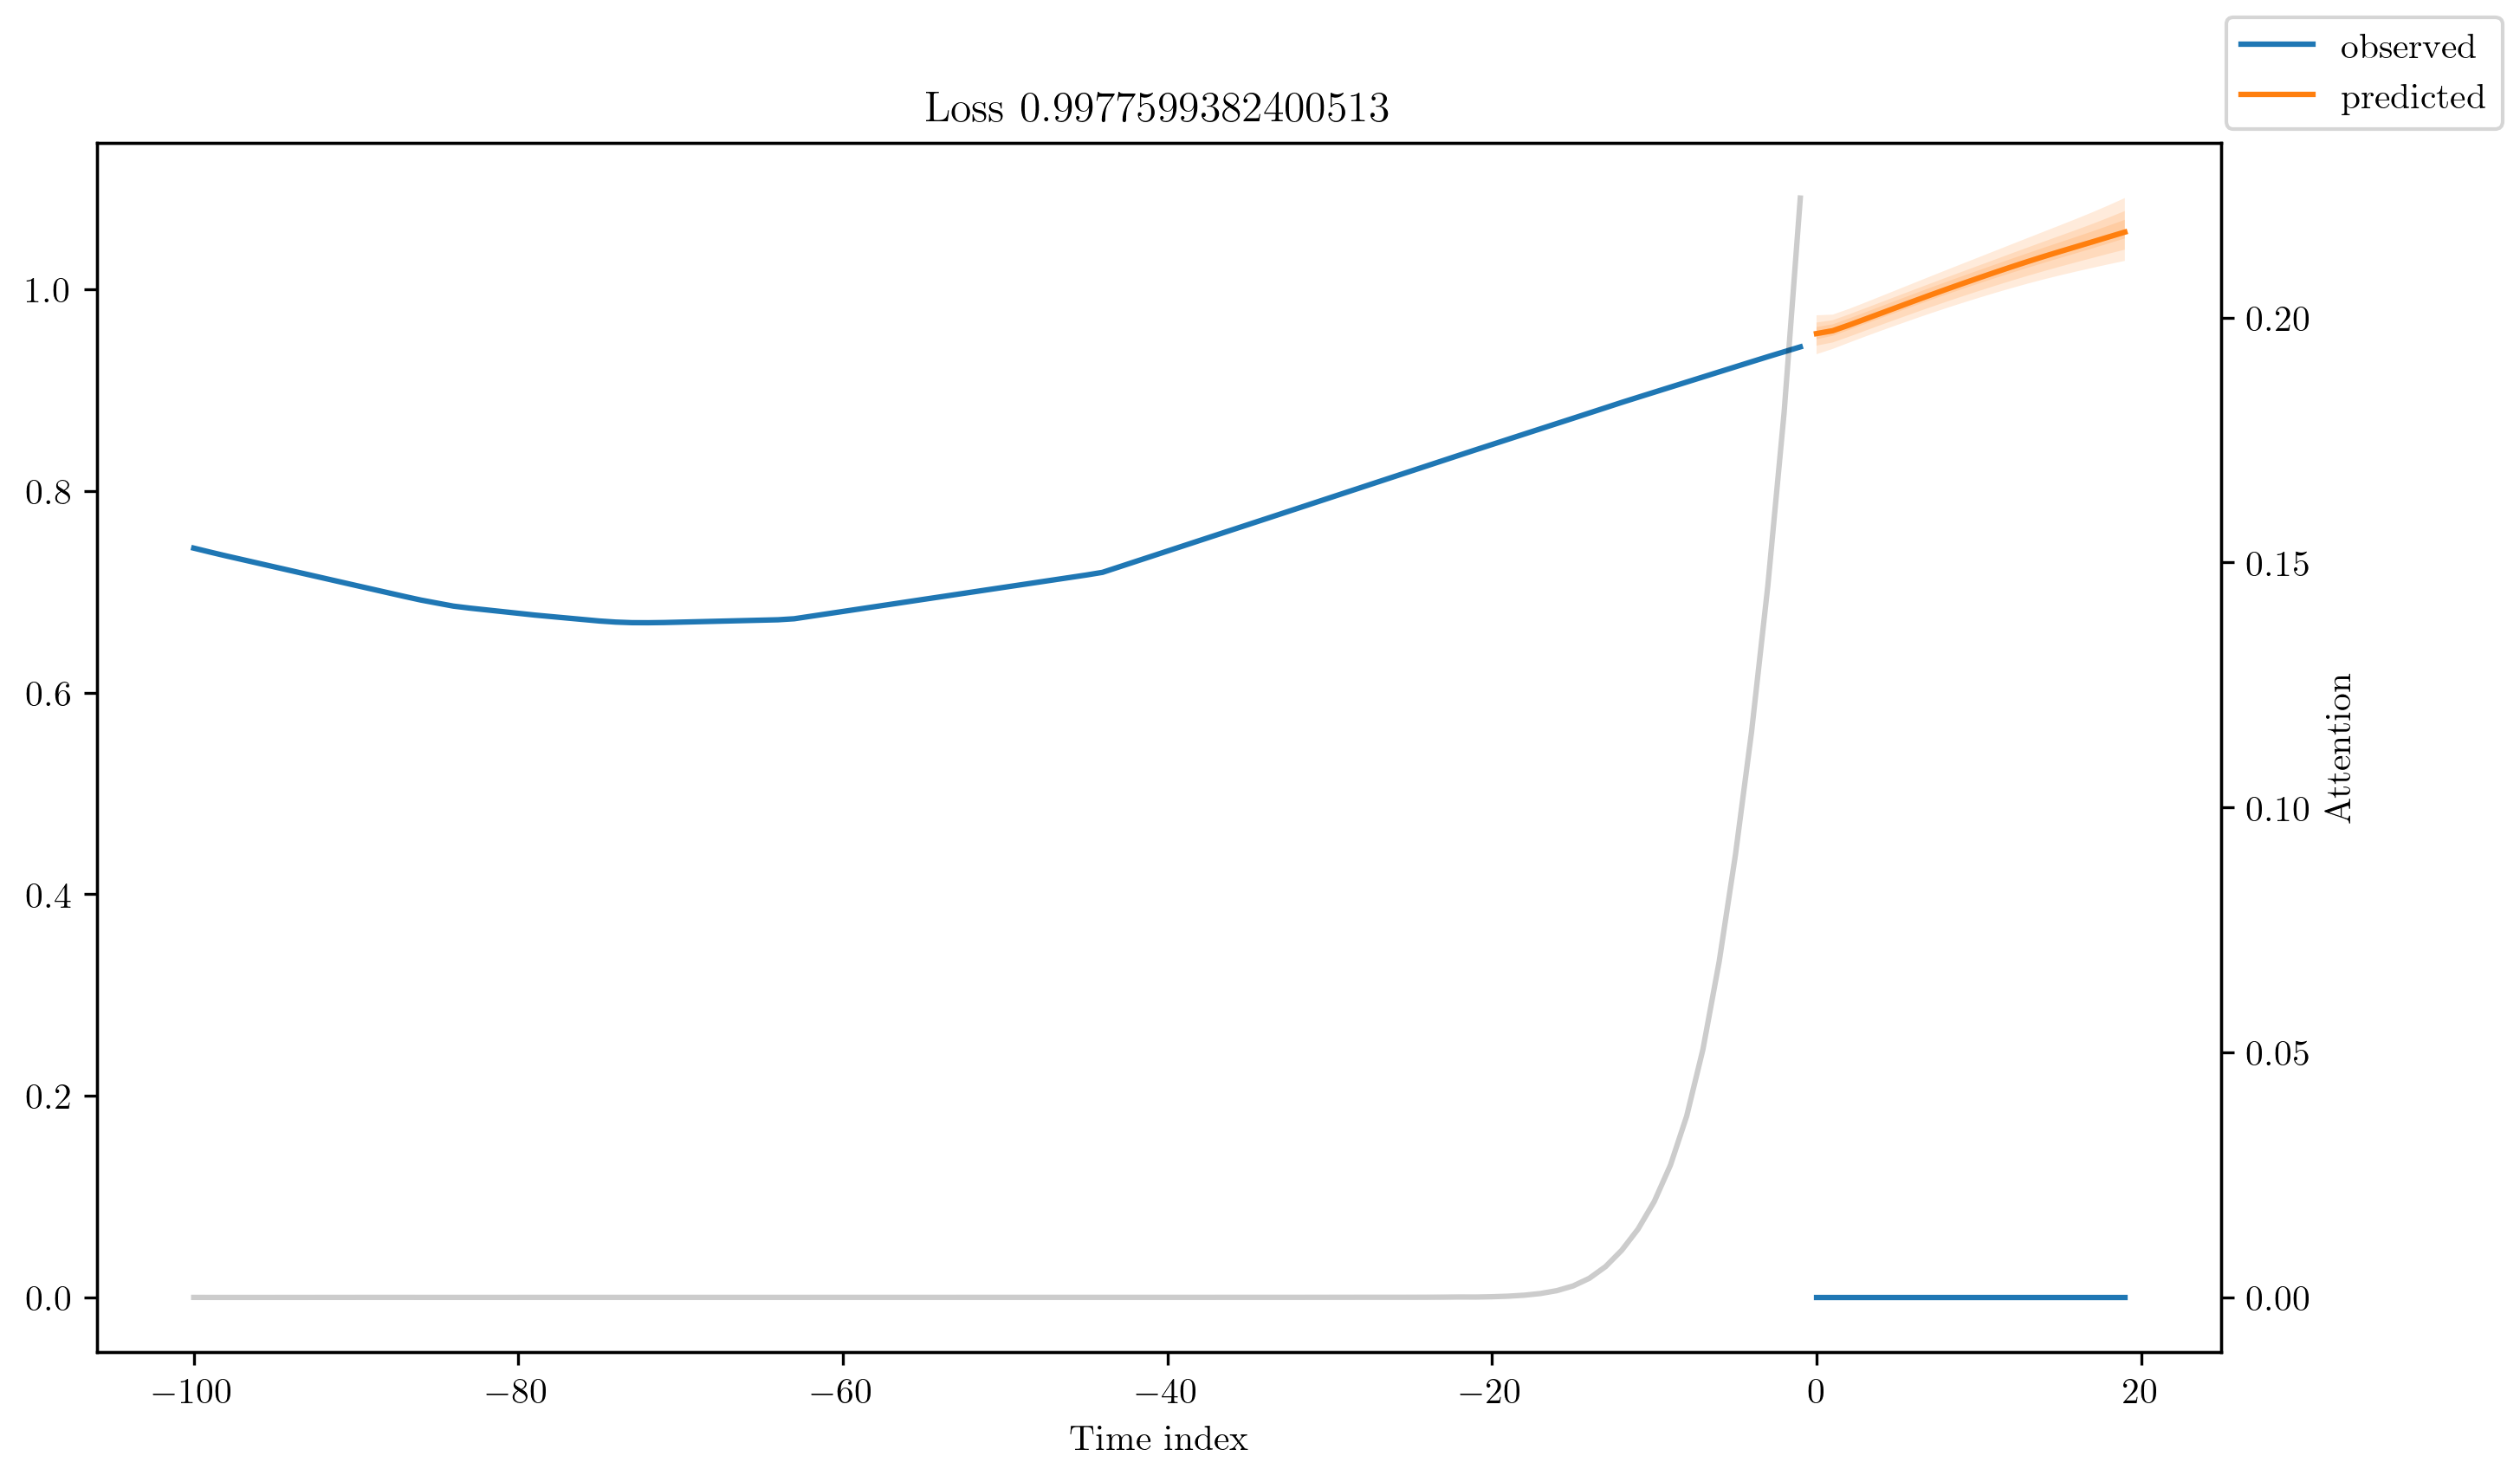

In [53]:
fig = best_model2.plot_prediction(x_new, raw_tests, idx=0, add_loss_to_title=True)
fig.set_dpi(300)
fig.set_figwidth(10)
fig.set_figheight(6)
fig.savefig("tft_predict_new.png")
fig.show()

In [54]:
def pred_step(n):
    # Last Observed Data + Dummy Decoded Data
    x_test = torch.concat([x_val['encoder_target'][:], torch.repeat_interleave(torch.tensor(0.0), 20)])
    
    # Container
    y_preds = []
    
    for i in range(n):
        ts_test = pd.DataFrame(
            dict(
                y=x_test,
                group=np.repeat(0, 120),
                time_idx=np.arange(880+20*i,1000+20*i)
            )
        )
        ts_test = ts_test.astype(dict(group=str))

        # DataFrame to TimeSeriesDataSet
        ds_test = TimeSeriesDataSet(
            ts_test,
            target="y",
            time_idx="time_idx",
            group_ids=["group"],
            time_varying_known_reals=["time_idx"],
            time_varying_unknown_reals=["y"],
            max_encoder_length=max_encoder_length,
            max_prediction_length=max_prediction_length
        )
        
        # Prediction
        y_new = best_model2.predict(ds_test)[0]
        y_preds.extend(y_new.detach().cpu().tolist())
        
        # Update Data
        x_test = torch.concat([x_test[20:100], y_new, torch.repeat_interleave(torch.tensor(0.0), 20)])
    
    return torch.tensor(y_preds)

In [55]:
test_data = gen_noisy_data(1500, range_x=[-2,4], sc=sc)
x = test_data.x
y = test_data.y
y_true = test_data.y_true
y_hat = best_model(x).detach().cpu().numpy()

In [56]:
y_preds = pred_step(26)
x_preds = x[980:]

In [57]:
test_data = gen_noisy_data(1500, range_x=[-2,4], sc=sc)
x = test_data.x
y = test_data.y
y_true = test_data.y_true
y_hat = best_model(x).detach().cpu().numpy()

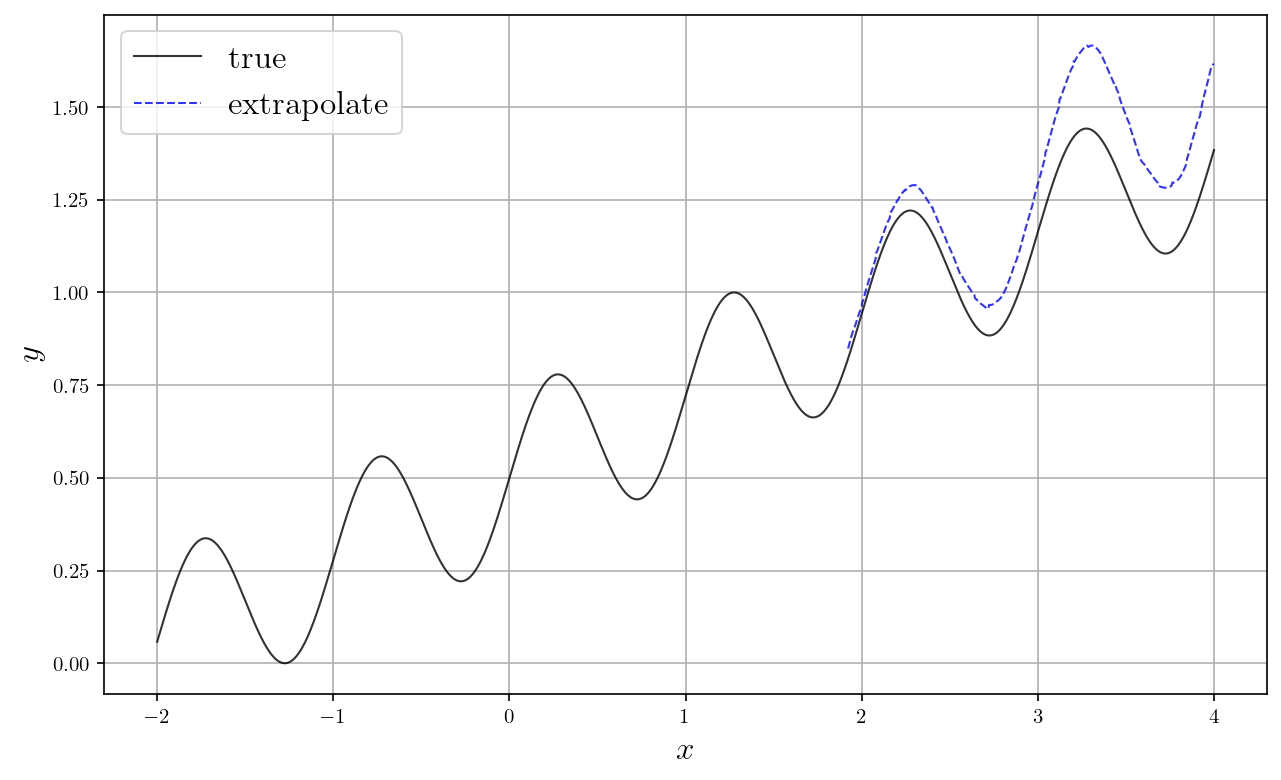

In [58]:
plt.figure(figsize=(10, 6), dpi=150)
plt.plot(x, y_true, 'k-', linewidth=1, label='true', alpha=0.8)
plt.plot(x_preds, y_preds, 'b--', linewidth=1, label='extrapolate', alpha=0.8)
plt.legend(fontsize=16)
plt.grid()
plt.xlabel(r"$x$", fontsize=16)
plt.ylabel(r"$y$", fontsize=16)
# plt.xlim([1.5, 2.0])
# plt.ylim([0.6, 1.0])
plt.show()

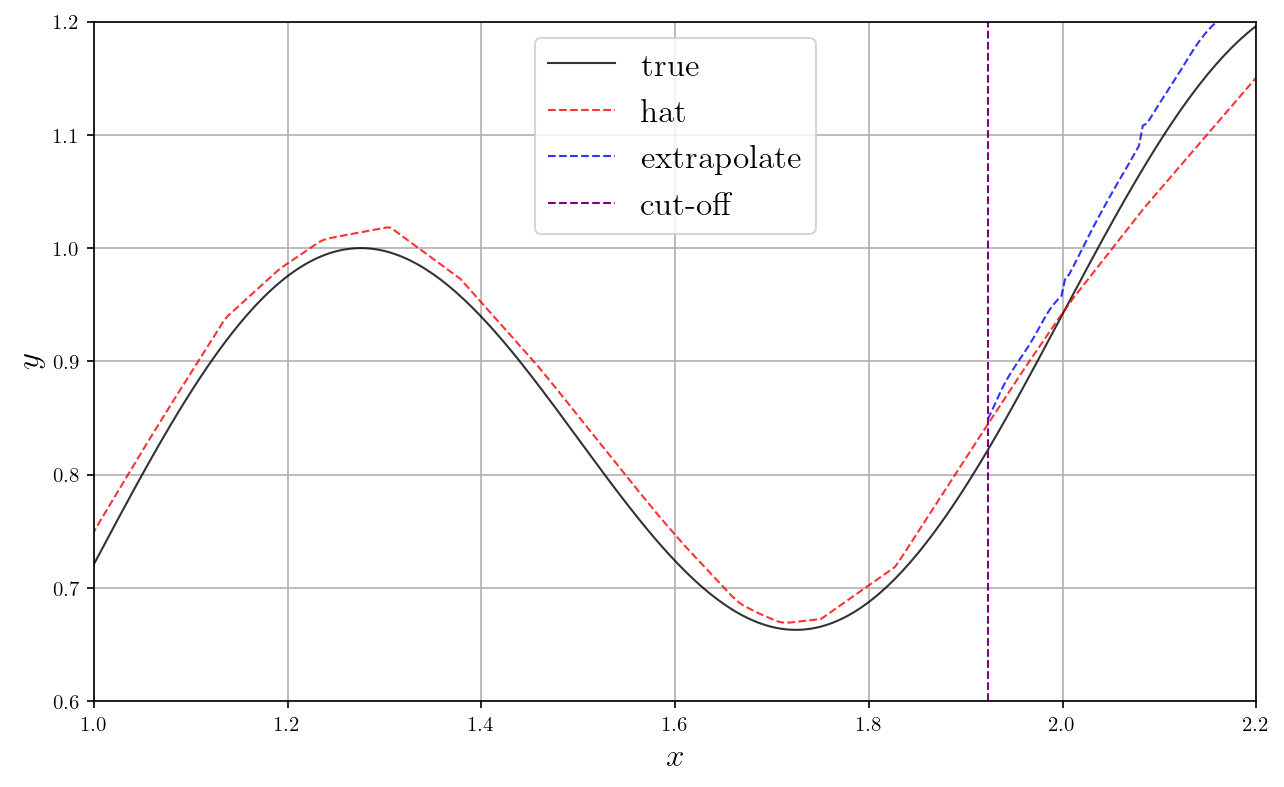

In [59]:
plt.figure(figsize=(10, 6), dpi=150)
plt.plot(x, y_true, 'k-', linewidth=1, label='true', alpha=0.8)
plt.plot(x, y_hat, 'r--', linewidth=1, label='hat', alpha=0.8)
# plt.plot(x[:980], best_model2.predict(ds_train), 'g--', linewidth=1, label='pred', alpha=0.8)
plt.plot(x_preds, y_preds, 'b--', linewidth=1, label='extrapolate', alpha=0.8)
plt.axvline(x_preds[0], color='purple', linewidth=1, linestyle='dashed', label='cut-off')
plt.legend(fontsize=16)
plt.grid()
plt.xlabel(r"$x$", fontsize=16)
plt.ylabel(r"$y$", fontsize=16)

plt.xlim([1.0, 2.2])
plt.ylim([0.6, 1.2])

# plt.savefig("rnn_extrapolate.png")
plt.show()